In [1]:
import os
import pandas as pd
import utils as utils

DATA_PATH = '../../backend/data/database/'

In [2]:
participants_df = pd.read_parquet(os.path.join(DATA_PATH, 'participants.parquet'))
participants_df.shape

(74, 8)

In [3]:
participants_df.sample(10)

,ParticipantId,TreatmentGroup,PoliticalLeaning,Tweet1,Tweet2,Tweet3,Tweet4,ParticipantStatus
17,5fc76a1218360601e2b18ed9,human,5.0,L113,L019,R178,R125,finished
62,667d9e3136e04a629c3f290d,human,3.0,R009,L719,R250,L145,finished
51,66072bcf065f7722b6e6ec0c,human,3.0,R151,L894,R186,L092,finished
16,5fa30c6baab6c25b14747b36,human,3.0,R707,R147,L555,L269,finished
66,66b3ace64c9b2e3f3dc2a60b,machine,3.0,R327,L817,R441,L854,finished
43,64532687f92beccab874da1c,placebo,2.0,R372,R879,L991,L458,finished
39,616a9aed70afcdbfbf43daca,placebo,3.0,R011,L875,L505,R589,finished
14,5f3692bf1640190638ebb687,placebo,2.0,R381,L181,R422,L262,finished
22,608b1ac239a12b93a41241bb,human,2.0,L872,R768,R909,L047,finished
31,61215755cea9b916eef0a38b,machine,2.0,L048,R328,R036,L472,finished


In [4]:
# selecting participants that finished the survey
qualif_participants = participants_df.loc[participants_df['ParticipantStatus']=='finished'].reset_index(drop=True)
qualif_participants.shape

(71, 8)

In [5]:
qualif_participants['PoliticalLeaning'] = qualif_participants['PoliticalLeaning'].map(lambda x: utils.proc_participant_leaning(x))
qualif_participants['PoliticalLeaning'].value_counts()

PoliticalLeaning
center-left     24
left            17
center-right     9
center           6
not informed     5
right            5
far-left         2
far-right        1
Name: count, dtype: int64

<Axes: xlabel='PoliticalLeaning'>

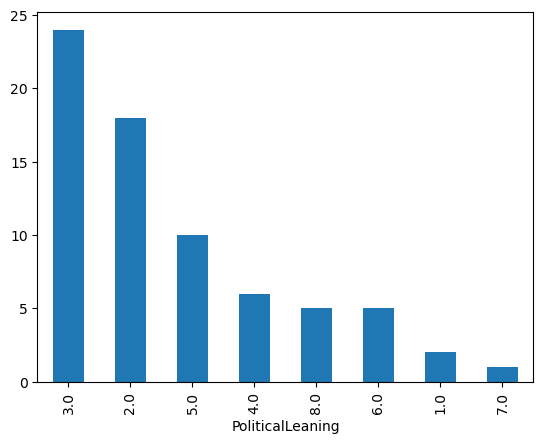

In [5]:
qualif_participants['PoliticalLeaning'].value_counts().plot.bar()

In [6]:
qualif_participants['TreatmentGroup'].value_counts()

TreatmentGroup
machine    25
placebo    23
human      23
Name: count, dtype: int64

In [7]:
answers_df = pd.read_parquet(os.path.join(DATA_PATH, 'answers.parquet'))
answers_df.dropna(axis=0, how='any', inplace=True)
answers_df.shape

(284, 10)

In [8]:
# selecting answer from qualified participants
qualif_answers = answers_df.loc[answers_df['FK_ParticipantId'].isin(qualif_participants['ParticipantId'].values)].reset_index(drop=True)
qualif_answers.shape

(284, 10)

In [9]:
qualif_answers.head(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent
0,57bb0ebfd4654c00018e0261T1,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR749,R749,4.0,5.0,5.0,2.0,44
1,57bb0ebfd4654c00018e0261T2,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,L167,ML167,3.0,3.0,5.0,3.0,43
2,57bb0ebfd4654c00018e0261T3,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,MR050,R050,2.0,5.0,4.0,2.0,58
3,57bb0ebfd4654c00018e0261T4,57bb0ebfd4654c00018e0261,671179cfd13e2cb0dc00fee4,ML633,L633,4.0,4.0,5.0,2.0,64
4,5ab848ffe1546900019b6ec9T1,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L211,ML211,5.0,2.0,4.0,1.0,59
5,5ab848ffe1546900019b6ec9T2,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,L891,ML891,5.0,2.0,4.0,1.0,55
6,5ab848ffe1546900019b6ec9T3,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,MR942,R942,4.0,5.0,2.0,2.0,66
7,5ab848ffe1546900019b6ec9T4,5ab848ffe1546900019b6ec9,671793db2e378b0de8b1321d,R528,MR528,4.0,2.0,4.0,1.0,40
8,5c131126d6d169000148414aT1,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,PL159,L159,4.0,4.0,5.0,1.0,59
9,5c131126d6d169000148414aT2,5c131126d6d169000148414a,67152faa5a48814cd9e7a281,L482,PL482,4.0,4.0,4.0,3.0,21


In [10]:
new_values = []

for idx, row in qualif_answers.iterrows():
    treated_polar, treated_likert, original_polar, original_likert = utils.get_polar_info(row)
    treated_less_polar = utils.is_treated_less_polar(row)
    diff_likert_treated_original = utils.get_treat_diff(row)
    tweet_bias = utils.proc_tweet_bias(utils.get_tt_bias(row['Text1']))
    participant_leaning = qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['PoliticalLeaning'].values[0]
    treatment_group = qualif_participants.loc[qualif_participants['ParticipantId']==row['FK_ParticipantId']]['TreatmentGroup'].values[0]
    new_values.append(
        {
            'TreatedIsPolarized' : treated_polar,
            'OriginalIsPolarized' : original_polar,
            'TreatedIsLessPolar' : treated_less_polar,
            'TreatedLikertValue' : treated_likert,
            'OriginalLikertValue' : original_likert,
            'DiffLikertTreatedOriginal' : diff_likert_treated_original,
            'TweetBias' : tweet_bias,
            'ParticipantLeaning' : participant_leaning,
            'TreatmentGroup' : treatment_group
        }
    )

In [11]:
new_columns = pd.DataFrame.from_records(new_values)
new_columns.sample(10)

,TreatedIsPolarized,OriginalIsPolarized,TreatedIsLessPolar,TreatedLikertValue,OriginalLikertValue,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
9,1,1,0,4,4,0,Left,3.0,placebo
140,1,1,1,4,5,-1,Left,2.0,human
7,0,1,1,2,4,-2,Right,4.0,machine
275,1,1,1,4,4,0,Left,6.0,human
254,-1,1,1,3,4,-1,Right,3.0,machine
211,1,1,0,5,5,0,Right,2.0,placebo
205,0,1,0,2,4,-2,Left,4.0,machine
119,1,1,0,5,5,0,Left,2.0,machine
221,1,1,0,5,5,0,Right,3.0,placebo
162,-1,1,1,3,4,-1,Left,8.0,human


In [12]:
answers_data = pd.concat([qualif_answers, new_columns], axis=1)
answers_data.sample(10)

,AnswerId,FK_ParticipantId,FK_SessionId,Text1,Text2,AnswerQ1,AnswerQ2,AnswerQ3,AnswerQ4,TimeSpent,TreatedIsPolarized,OriginalIsPolarized,TreatedIsLessPolar,TreatedLikertValue,OriginalLikertValue,DiffLikertTreatedOriginal,TweetBias,ParticipantLeaning,TreatmentGroup
23,5d160cd4e639230001e95fc0T4,5d160cd4e639230001e95fc0,672dedd82c4731d9f83557dd,HR784,R784,2.0,5.0,2.0,2.0,46,0,1,1,2,5,-3,Right,8.0,human
167,64532687f92beccab874da1cT4,64532687f92beccab874da1c,672bed06a1f9a800fcbd3e73,PL458,L458,4.0,4.0,4.0,3.0,16,1,1,0,4,4,0,Left,2.0,placebo
163,6346e2da58119734e201d767T4,6346e2da58119734e201d767,67122494bda0b990fc5cea3d,HR388,R388,2.0,2.0,5.0,3.0,31,0,0,0,2,2,0,Right,8.0,human
124,612ab0385e15625a6efe9daaT1,612ab0385e15625a6efe9daa,671e54ac5e5e3f340a6f28a1,L252,HL252,5.0,3.0,5.0,1.0,89,-1,1,1,3,5,-2,Left,7.0,human
138,61557115001e33cd457a1230T3,61557115001e33cd457a1230,673ca2e75dcbb2c5f8969dd1,ML856,L856,1.0,5.0,2.0,2.0,29,0,1,1,1,5,-4,Left,3.0,machine
97,60cb07e335a3ead69def5309T2,60cb07e335a3ead69def5309,672237b94844d85b6a208713,L937,HL937,2.0,1.0,4.0,1.0,61,0,0,1,1,2,-1,Left,5.0,human
189,65b12168f1736582e24e18ebT2,65b12168f1736582e24e18eb,67379ad2d5473813c7a5dd67,R605,MR605,3.0,2.0,4.0,3.0,35,0,-1,0,2,3,-1,Right,2.0,machine
83,608b1ac239a12b93a41241bbT4,608b1ac239a12b93a41241bb,67121a5bb57f47dcac23bd95,HL047,L047,2.0,4.0,2.0,2.0,40,0,1,1,2,4,-2,Left,2.0,human
264,66ccf8abf9e250aa74ab1d3fT1,66ccf8abf9e250aa74ab1d3f,672ca6a6249de4f50ff42e37,R227,HR227,5.0,5.0,4.0,1.0,99,1,1,1,5,5,0,Right,5.0,human
74,601deb10b1f15322f2887850T3,601deb10b1f15322f2887850,6718d49a5ffc8fe932a604f0,L221,HL221,5.0,5.0,4.0,2.0,65,1,1,0,5,5,0,Left,2.0,human


In [13]:
answers_data.to_parquet(os.path.join(DATA_PATH, 'survey_data.parquet'), index=False)
answers_data.to_csv(os.path.join(DATA_PATH, 'survey_data.csv'), index=False)

In [14]:
answers_data.loc[answers_data['TreatmentGroup']=='machine']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
1    76
0    24
Name: count, dtype: int64

In [15]:
answers_data.loc[answers_data['TreatmentGroup']=='human']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
1    81
0    11
Name: count, dtype: int64

In [16]:
answers_data.loc[answers_data['TreatmentGroup']=='placebo']['TreatedIsLessPolar'].value_counts()

TreatedIsLessPolar
0    64
1    28
Name: count, dtype: int64